In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt


#np.savez_compressed('tt_leading_jet.npz', li_ttImgs)
#np.savez_compressed('ztt_leading_jet.npz',li_zttImgs)


f = h5py.File('jetImages.h5','r')
x_train = f.get("x_train").value
x_test  = f.get("x_test").value

y_train = f.get("y_train").value
y_test  = f.get("y_test").value


/home/rnarayan/.conda/envs/hls4ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/home/rnarayan/.conda/envs/hls4ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/home/rnarayan/.conda/envs/hls4ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/rnarayan/.conda/envs/hls4ml/lib/python3.7/site-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

#model_cnn = Sequential()
#model_cnn.add(Conv2D(32, (3, 3), input_shape=(30, 30,1), activation='relu'))
#model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

#model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

#model_cnn.add(Flatten())
#model_cnn.add(Dense(300, activation='relu'))
#model_cnn.add(Dropout(0.5))
#model_cnn.add(Dense(2, activation='softmax'))

# Compile model

#model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=1024, shuffle=True, verbose=1)

In [3]:
model_cnn = Sequential()
model_cnn.add(Conv2D(4, (3, 3), activation='relu', input_shape=(30, 30, 1)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(8, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(16, (3, 3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=1024, shuffle=True, verbose=1)
model_cnn.summary()

Epoch 1/40
105/105 [==============================] - 1s 10ms/step - loss: 31.6207 - accuracy: 0.5319 - val_loss: 16.0108 - val_accuracy: 0.5039
Epoch 2/40
105/105 [==============================] - 1s 8ms/step - loss: 9.3454 - accuracy: 0.5455 - val_loss: 7.5741 - val_accuracy: 0.5621
Epoch 3/40
105/105 [==============================] - 1s 7ms/step - loss: 5.4983 - accuracy: 0.5673 - val_loss: 5.5862 - val_accuracy: 0.5748
Epoch 4/40
105/105 [==============================] - 1s 7ms/step - loss: 3.7736 - accuracy: 0.5744 - val_loss: 4.7053 - val_accuracy: 0.5204
Epoch 5/40
105/105 [==============================] - 1s 7ms/step - loss: 3.0408 - accuracy: 0.5877 - val_loss: 3.1099 - val_accuracy: 0.5971
Epoch 6/40
105/105 [==============================] - 1s 7ms/step - loss: 2.4628 - accuracy: 0.5953 - val_loss: 2.9808 - val_accuracy: 0.5584
Epoch 7/40
105/105 [==============================] - 1s 7ms/step - loss: 2.1059 - accuracy: 0.5901 - val_loss: 2.1022 - val_accuracy: 0.5928
Epo

### Prune model

In [4]:
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

config = {
  #"conv2d_10": {
  #    "kernel_quantizer": "stochastic_binary",
  #    "bias_quantizer": "quantized_po2(4)"
  #},
  #"conv2d_11": {
  #    "kernel_quantizer": "stochastic_binary",
  #    "bias_quantizer": "quantized_po2(4)"
  #},
  "QConv2D": {
      "kernel_quantizer": "stochastic_ternary",
      "bias_quantizer": "quantized_po2(4)"
  },
  "QDense": {
      "kernel_quantizer": "quantized_bits(4,0,1)",
      "bias_quantizer": "quantized_bits(4)"
  },
  "QActivation": { "relu": "binary" },
  "act_2": "quantized_relu(3)",
}

from qkeras.utils import model_quantize
qmodel = model_quantize(model_cnn, config, 4, transfer_weights=True)


for layer in qmodel.layers:
    if hasattr(layer, "kernel_quantizer"):
        print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
    elif hasattr(layer, "quantizer"):
        print(layer.name, "quantizer:", str(layer.quantizer))

qmodel.summary()
model_cnn.summary()

from tensorflow.keras.optimizers import Adam
qmodel.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.001),
    metrics=["accuracy"])


history_cnn = qmodel.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=1024, shuffle=True, verbose=1)


conv2d kernel: stochastic_ternary(alpha='auto_po2') bias: quantized_po2(4)
conv2d_1 kernel: stochastic_ternary(alpha='auto_po2') bias: quantized_po2(4)
conv2d_2 kernel: stochastic_ternary(alpha='auto_po2') bias: quantized_po2(4)
dense kernel: quantized_bits(4,0,1,alpha='auto_po2') bias: quantized_bits(4,0,0)
dense_1 kernel: quantized_bits(4,0,1,alpha='auto_po2') bias: quantized_bits(4,0,0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (QConv2D)             (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_1 (QConv2D)           (None, 12, 12, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 8)           0   

Epoch 36/40
105/105 [==============================] - 2s 16ms/step - loss: 0.6239 - accuracy: 0.6585 - val_loss: 0.6202 - val_accuracy: 0.6622
Epoch 37/40
105/105 [==============================] - 2s 16ms/step - loss: 0.6199 - accuracy: 0.6637 - val_loss: 0.6214 - val_accuracy: 0.6628
Epoch 38/40
105/105 [==============================] - 2s 16ms/step - loss: 0.6218 - accuracy: 0.6626 - val_loss: 0.6287 - val_accuracy: 0.6575
Epoch 39/40
105/105 [==============================] - 2s 17ms/step - loss: 0.6142 - accuracy: 0.6701 - val_loss: 0.6243 - val_accuracy: 0.6561
Epoch 40/40
105/105 [==============================] - 2s 16ms/step - loss: 0.6167 - accuracy: 0.6666 - val_loss: 0.6213 - val_accuracy: 0.6648


In [5]:
#x_train
predictions_cnn = model_cnn.predict(x_test)
predictions_q   = qmodel.predict(x_test)
#qmodel.save('q_cnn.h5')
#model_cnn.save('cnn.h5')

# Hyper parameter optimization using kerasTune


In [6]:
import kerastuner as kt
from kerastuner.tuners import Hyperband

from qkeras import QActivation
from qkeras import QDense, QConv2D
from qkeras import quantized_bits
from qkeras import QBatchNormalization
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten,ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D, GlobalMaxPooling2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Model




def buildmodel(hp):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, (3, 3), input_shape=(30, 30,1), activation='relu'))
    model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    
    model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    
    model_cnn.add(Flatten())
    model_cnn.add(Dense(300, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(2, activation='softmax'))

def qkeras_cnn(name_, Inputs,nclasses,filters,kernel,strides,
               pooling, dropout, activation, pruning_params = {},qb=quantized_bits(6,0,alpha=1)):
    length = len(filters)
    if any(len(lst) != length for lst in [filters, kernel, strides,pooling,dropout]):
        sys.exit("One value for stride and kernel must be added for each filter! Exiting") 
    x = x_in = Inputs
    x = BatchNormalization()(x)
    x = ZeroPadding2D( padding=(1, 1), data_format="channels_last") (x)
    for i,(f,k,s,p,d) in enumerate(zip(filters,kernel,strides,pooling,dropout)):
        print (("Adding layer with {} filters, kernel_size=({},{}), strides=({},{})").format(f,k,k,s,s))
        x = QConv2D(int(f), kernel_size=(int(k), int(k)), strides=(int(s),int(s)),
                kernel_quantizer=qb, bias_quantizer=qb,
                kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=False, name='conv_%i'%i)(x) 
        if float(p) != 0:
            x = MaxPooling2D(pool_size = (int(p),int(p)) )(x)
        x = BatchNormalization()(x)
        x = Activation(activation,name='conv_act_%i'%i)(x)
    x = Flatten()(x)
    x = QDense(128,kernel_quantizer=qb, bias_quantizer=qb,kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_1', use_bias=False)(x)
    x = Dropout(0.25) (x)
    x = BatchNormalization()(x)
    x = Activation(activation,name='dense_act')(x)
    x_out = Dense(nclasses, activation='softmax',name='output')(x)
    model = Model(inputs=[x_in], outputs=[x_out], name=name_)
    return model


In [7]:
model_q = qkeras_cnn("qmodel",Input((30,30,1)),
                     2,
                     (16,16,24),
                     (3,3,1),
                     (1,1,1),
                     (2,2,2),
                     (0.0,0.0,0.0),
                     "relu",
                    )

Adding layer with 16 filters, kernel_size=(3,3), strides=(1,1)
Adding layer with 16 filters, kernel_size=(3,3), strides=(1,1)
Adding layer with 24 filters, kernel_size=(1,1), strides=(1,1)


In [8]:
def getCallbacks(outdir_):
    import tensorflow as tf
    callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
      tf.keras.callbacks.ModelCheckpoint(filepath=outdir_+'/model_best.h5',monitor="val_loss",verbose=0,save_best_only=True), 
      tf.keras.callbacks.ModelCheckpoint(filepath=outdir_+'/weights_best.h5',monitor="val_loss",verbose=0,save_weights_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6)
    ]


In [9]:
import tensorflow
from tensorflow.keras.optimizers import Adam

lr       = 3e-3
beta_1   = 0.9
beta_2   = 0.99
epsilon  = 1e-7

callback    = getCallbacks("prune_test")
LOSS        = tensorflow.keras.losses.CategoricalCrossentropy()
OPTIMIZER   = Adam(learning_rate=lr, beta_1=beta_1, 
                   beta_2=beta_2, epsilon=epsilon, amsgrad=True)
#model_q.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
#model_q.summary()

model_q.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
#history_q = model_q.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=1024, shuffle=True, verbose=1)

In [11]:
#predictions_q = model_q.predict(x_test)
#predictions_q = qmodel.predict(x_test)

In [12]:
from sklearn.metrics import roc_curve
fpr0, tpr0, thresholds = roc_curve(y_test.ravel(), predictions_cnn.ravel())
fpr1, tpr1, thresholds = roc_curve(y_test.ravel(), predictions_q.ravel())

from sklearn.metrics import auc
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)


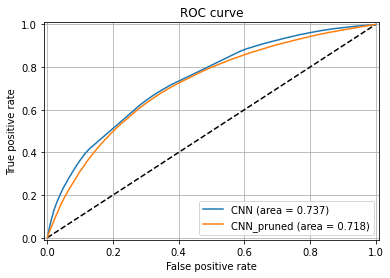

In [13]:
%matplotlib inline
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='CNN (area = {:.3f})'.format(auc0))
plt.plot(fpr1, tpr1, label='CNN_pruned (area = {:.3f})'.format(auc1))
plt.gca().set(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', xlim=(-0.01,1.01), ylim=(-0.01,1.01))
plt.grid(True, which="both")
plt.legend(loc='lower right');

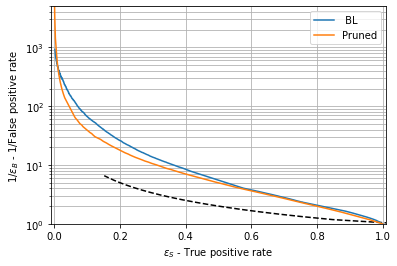

In [14]:
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(thresholds, 1/thresholds, 'k--')
plt.plot(tpr0, 1/fpr0, label=' BL ')
plt.plot(tpr1, 1/fpr1, label='Pruned')
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', 
              title='', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend();